In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

In [42]:
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models import ResNet
m = resnet50(replace_stride_with_dilation=[False, True, True])#(torch.randn(1, 3, 512, 512)).shape
m.avgpool = nn.Identity()
m.fc = nn.Identity()
m(torch.randn(1, 3, 512, 512)).reshape(1, -1, 512, 512).shape

# # for x in m.children():
# #     print(type(x))

# ResNet()

torch.Size([1, 32, 512, 512])

In [44]:
import torch.nn as nn
m = nn.ReflectionPad2d((1, 1, 1, 1))
m(torch.randn(1, 1, 512, 512)).shape

torch.Size([1, 1, 514, 514])

In [57]:
def make_layers(cfg, batch_norm: bool = False, invert=False):
    layers = []

    pool_l = lambda : nn.MaxPool2d(kernel_size=2, stride=2) if not invert else nn.UpsamplingNearest2d(scale_factor=2)
    cfg = cfg[::1 - 2*invert]

    in_channels = cfg[0]
    for v in cfg:
        if v == "M":
            layers += [pool_l()]
        else:
            v = int(v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_layers_inverse(cfg, batch_norm: bool = False):
    layers = []
    in_channels = 512
    for v in cfg[-2::-1] + [3]:
        if v == "M":
            layers += [nn.UpsamplingNearest2d(scale_factor=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
cfg = [3, 64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512]
encoder = make_layers(cfg)
decoder = make_layers(cfg, invert=True)
decoder(encoder(torch.randn(1, 3, 512, 512))).shape

torch.Size([1, 3, 512, 512])

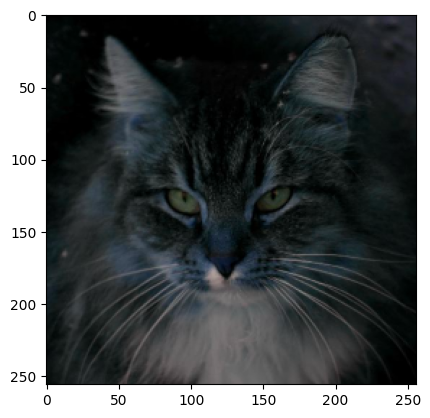

: 

In [7]:
from datamodule import AFHQDataset
from tqdm import tqdm
import zarr
import matplotlib.pyplot as plt

x = AFHQDataset('afhq/train', im_size=256)


plt.imshow(x[0].transpose(1, 2, 0))
# z = zarr.zeros((20000, 3, 512, 512), chunks=(500, 3, 256, 256), dtype='i4')

# for i, xx in enumerate(tqdm(x)):
#     # print(xx.shape)
#     z[i] = xx
#     # break

In [116]:
import torch
import functorch
from torch import nn
import torch.nn.functional as F

M = 5
bsize = 2

alpha = ((torch.arange(M + 1)/M) * torch.ones((bsize, 1))).reshape(-1, 1)
# alpha = torch.tensor([0.])
alpha.requires_grad_()
x = torch.randn(bsize*(M + 1), 2, 2, 2).flatten(start_dim=1)#.flatten(start_dim=1)

# print(alpha.reshape(-1, 1).shape)
# print((alpha[..., None, None, None] * x).reshape(-1, 8).shape)
# torch.gradient(alpha[..., None, None, None] * x, spacing=(alpha[0],), dim=1)

# print(x.reshape(-1, 8), alpha.shape)

# (alpha * x).shape#.reshape(-1, 8)
y = x*alpha
out, (aa, aaa) = torch.vmap(torch.func.jacfwd(lambda alpha, x: (x*alpha, (torch.tensor(alpha.shape), torch.tensor(alpha.shape))), has_aux=True))(alpha, x)# - x.reshape(-1, 8, 1))

In [118]:
aa.shape

torch.Size([12, 1])

In [110]:
# (x[:, None] + torch.zeros((1, 2, 8)))
x.repeat_interleave(2, dim=0) - (x[:, None] + torch.zeros((1, 2, 8))).reshape(24, 8)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0